In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras import layers, models
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201, DenseNet169, DenseNet121
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import Xception
from keras.applications import MobileNetV2
from keras.applications import MobileNet
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, cohen_kappa_score
import pandas as pd

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Using TensorFlow backend.


# Data Import and Preprocessing

In [2]:
IMG_PATH = 'brain_tumor_dataset/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/' + CLASS.upper() + '/' + FILE_NAME) 

In [3]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print('{} images loaded from {} directory.'.format(len(X), dir_path))
    return X, y, labels
    

In [4]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224, 224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.22s/it]
C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

564 images loaded from TRAIN/ directory.


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

68 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]

149 images loaded from VAL/ directory.


In [8]:
type(X_train)
X_train[4].shape

(197, 177, 3)

In [9]:
def preprocess_imgs(set_name, img_size):
    
    # Resize and apply VGG-15 preprocessing
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [10]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

In [11]:
X_train_prep.shape

(564, 224, 224, 3)

# CNN Pre-trained Models

## Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


Found 564 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


# Pre-trained Networks Evaluation

In [10]:
nets_evaluation_df = pd.DataFrame(columns=['Training Accuracy', 'Validation Accuracy', 'Test Accuracy', 'F1 Measure', 'Kappa', 'ROC Area', 'Confusion Matrix'])
EPOCHS = 30
NUM_CLASSES = 1
trained_nets = {VGG16 : 'VGG16', VGG19 : 'VGG19',  ResNet50 : 'ResNet50', ResNet101 : 'ResNet101', DenseNet201 : 'DenseNet201',
               DenseNet169 : 'DenseNet169', DenseNet121 : 'DenseNet121', InceptionV3 : 'InceptionV3', InceptionResNetV2 : 'InceptionResNetV2',
               Xception : 'Xception', MobileNetV2 : 'MobileNetV2', MobileNet : 'MobileNet'}

In [11]:

for net in trained_nets.keys():
    # loading base model
    base_model = net(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,))
    
    

    model= Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

    model.layers[0].trainable = False

    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(lr=1e-4),
        metrics=['accuracy'])

    #model.summary()
    
    
    history = model.fit(
                    train_generator, steps_per_epoch=len(train_generator),
                    epochs=EPOCHS, validation_data=validation_generator,
                    validation_steps=len(validation_generator))
    
    # validate on test set    
    predictions = model.predict(X_test_prep)
    predictions = [1 if x>0.5 else 0 for x in predictions]

    acc = history.history['accuracy']
    
    val_acc = history.history['val_accuracy']

    test_accuracy = accuracy_score(y_test, predictions)

    kappa_score = cohen_kappa_score(y_test, predictions)

    roc_area = roc_auc_score(y_test, predictions)

    (precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')
    
    confusion_mtrx = confusion_matrix(y_test, predictions)
    
    measures = [acc[-1], val_acc[-1], test_accuracy, fscore, kappa_score, roc_area, confusion_mtrx]

    nets_evaluation_df.loc[trained_nets[net]] = measures

Epoch 1/30
36/36 [==============================] - 7s 192ms/step - loss: 3.2121 - accuracy: 0.6330 - val_loss: 1.8321e-04 - val_accuracy: 0.8322
Epoch 2/30
36/36 [==============================] - 6s 165ms/step - loss: 3.1432 - accuracy: 0.6755 - val_loss: 1.7469 - val_accuracy: 0.8322
Epoch 3/30
36/36 [==============================] - 6s 165ms/step - loss: 2.5848 - accuracy: 0.7039 - val_loss: 2.5482e-04 - val_accuracy: 0.8658
Epoch 4/30
36/36 [==============================] - 6s 167ms/step - loss: 2.1619 - accuracy: 0.7465 - val_loss: 1.1535 - val_accuracy: 0.8658
Epoch 5/30
36/36 [==============================] - 6s 165ms/step - loss: 2.3703 - accuracy: 0.7677 - val_loss: 3.2582 - val_accuracy: 0.8725
Epoch 6/30
36/36 [==============================] - 6s 165ms/step - loss: 1.8213 - accuracy: 0.7855 - val_loss: 1.1161e-04 - val_accuracy: 0.8658
Epoch 7/30
36/36 [==============================] - 6s 164ms/step - loss: 1.8490 - accuracy: 0.7979 - val_loss: 0.7955 - val_accuracy: 0

Epoch 28/30
36/36 [==============================] - 6s 178ms/step - loss: 0.7601 - accuracy: 0.8848 - val_loss: 0.1480 - val_accuracy: 0.9329
Epoch 29/30
36/36 [==============================] - 6s 175ms/step - loss: 0.5540 - accuracy: 0.9025 - val_loss: 3.2488e-04 - val_accuracy: 0.9396
Epoch 30/30
36/36 [==============================] - 6s 177ms/step - loss: 0.9261 - accuracy: 0.8582 - val_loss: 1.1481e-05 - val_accuracy: 0.9463


C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning:

The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.



Epoch 1/30
36/36 [==============================] - 10s 278ms/step - loss: 0.8038 - accuracy: 0.6862 - val_loss: 2.1853 - val_accuracy: 0.5369
Epoch 2/30
36/36 [==============================] - 5s 150ms/step - loss: 0.6384 - accuracy: 0.7465 - val_loss: 1.8318 - val_accuracy: 0.5168
Epoch 3/30
36/36 [==============================] - 6s 172ms/step - loss: 0.5732 - accuracy: 0.8085 - val_loss: 2.4957 - val_accuracy: 0.5638
Epoch 4/30
36/36 [==============================] - 6s 171ms/step - loss: 0.5469 - accuracy: 0.8280 - val_loss: 1.0314 - val_accuracy: 0.5436
Epoch 5/30
36/36 [==============================] - 6s 171ms/step - loss: 0.4122 - accuracy: 0.8564 - val_loss: 2.2523 - val_accuracy: 0.5638
Epoch 6/30
36/36 [==============================] - 6s 171ms/step - loss: 0.4275 - accuracy: 0.8333 - val_loss: 0.2123 - val_accuracy: 0.5839
Epoch 7/30
36/36 [==============================] - 6s 171ms/step - loss: 0.3709 - accuracy: 0.8812 - val_loss: 1.9253 - val_accuracy: 0.5369
Epoch

C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/30
36/36 [==============================] - 16s 432ms/step - loss: 0.8597 - accuracy: 0.6011 - val_loss: 3.7748 - val_accuracy: 0.5973
Epoch 2/30
36/36 [==============================] - 7s 185ms/step - loss: 0.5974 - accuracy: 0.7305 - val_loss: 3.0857e-07 - val_accuracy: 0.6040
Epoch 3/30
36/36 [==============================] - 7s 185ms/step - loss: 0.5879 - accuracy: 0.7695 - val_loss: 0.6809 - val_accuracy: 0.5705
Epoch 4/30
36/36 [==============================] - 7s 189ms/step - loss: 0.5236 - accuracy: 0.7855 - val_loss: 2.8503 - val_accuracy: 0.6107
Epoch 5/30
36/36 [==============================] - 7s 188ms/step - loss: 0.4703 - accuracy: 0.8156 - val_loss: 0.8273 - val_accuracy: 0.5973
Epoch 6/30
36/36 [==============================] - 7s 186ms/step - loss: 0.4376 - accuracy: 0.8262 - val_loss: 0.2360 - val_accuracy: 0.5973
Epoch 7/30
36/36 [==============================] - 7s 188ms/step - loss: 0.3817 - accuracy: 0.8635 - val_loss: 1.5413 - val_accuracy: 0.4765
E

36/36 [==============================] - 7s 199ms/step - loss: 0.2861 - accuracy: 0.8883 - val_loss: 132.7050 - val_accuracy: 0.3893
Epoch 26/30
36/36 [==============================] - 7s 199ms/step - loss: 0.2723 - accuracy: 0.8883 - val_loss: 175.3472 - val_accuracy: 0.3893
Epoch 27/30
36/36 [==============================] - 7s 199ms/step - loss: 0.3109 - accuracy: 0.8777 - val_loss: 113.0438 - val_accuracy: 0.3893
Epoch 28/30
36/36 [==============================] - 7s 208ms/step - loss: 0.2585 - accuracy: 0.8954 - val_loss: 206.1721 - val_accuracy: 0.3893
Epoch 29/30
36/36 [==============================] - 7s 199ms/step - loss: 0.2694 - accuracy: 0.8830 - val_loss: 91.1866 - val_accuracy: 0.3893
Epoch 30/30
36/36 [==============================] - 7s 199ms/step - loss: 0.2752 - accuracy: 0.8972 - val_loss: 86.3487 - val_accuracy: 0.3893


C:\Users\zeyne\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/30
36/36 [==============================] - 10s 274ms/step - loss: 0.6259 - accuracy: 0.6791 - val_loss: 1.3219 - val_accuracy: 0.6107
Epoch 2/30
36/36 [==============================] - 6s 173ms/step - loss: 0.4952 - accuracy: 0.7500 - val_loss: 5.8256e-06 - val_accuracy: 0.6107
Epoch 3/30
36/36 [==============================] - 7s 187ms/step - loss: 0.4582 - accuracy: 0.7961 - val_loss: 6.4068 - val_accuracy: 0.6107
Epoch 4/30
36/36 [==============================] - 7s 187ms/step - loss: 0.4002 - accuracy: 0.8227 - val_loss: 5.5067 - val_accuracy: 0.6174
Epoch 5/30
36/36 [==============================] - 7s 186ms/step - loss: 0.3500 - accuracy: 0.8440 - val_loss: 3.0357 - val_accuracy: 0.57050s - loss: 0.3464 - accuracy: 0.
Epoch 6/30
36/36 [==============================] - 7s 186ms/step - loss: 0.3361 - accuracy: 0.8564 - val_loss: 0.8892 - val_accuracy: 0.4698
Epoch 7/30
36/36 [==============================] - 7s 191ms/step - loss: 0.3516 - accuracy: 0.8316 - val_loss:

In [12]:
nets_evaluation_df

,Training Accuracy,Validation Accuracy,Test Accuracy,F1 Measure,Kappa,ROC Area,Confusion Matrix
VGG16,0.918440,0.959732,0.955882,0.953626,0.907441,0.946429,"[[25, 3], [0, 40]]"
VGG19,0.858156,0.946309,0.926471,0.924495,0.849023,0.926786,"[[26, 2], [3, 37]]"
ResNet50,0.946809,0.771812,0.735294,0.733217,0.501629,0.775000,"[[28, 0], [18, 22]]"
ResNet101,0.932624,0.879195,0.882353,0.881430,0.764706,0.894643,"[[27, 1], [7, 33]]"
DenseNet201,0.929078,0.617450,0.588235,0.370370,0.000000,0.500000,"[[0, 28], [0, 40]]"
DenseNet169,0.913121,0.402685,0.441176,0.388258,0.015244,0.508929,"[[25, 3], [35, 5]]"
DenseNet121,0.881206,0.718121,0.617647,0.552178,0.146718,0.567857,"[[8, 20], [6, 34]]"
InceptionV3,0.858156,0.516779,0.455882,0.398518,-0.180113,0.414286,"[[5, 23], [14, 26]]"
InceptionResNetV2,0.897163,0.389262,0.411765,0.291667,0.000000,0.500000,"[[28, 0], [40, 0]]"
Xception,0.906028,0.550336,0.544118,0.496055,0.011257,0.505357,"[[8, 20], [11, 29]]"


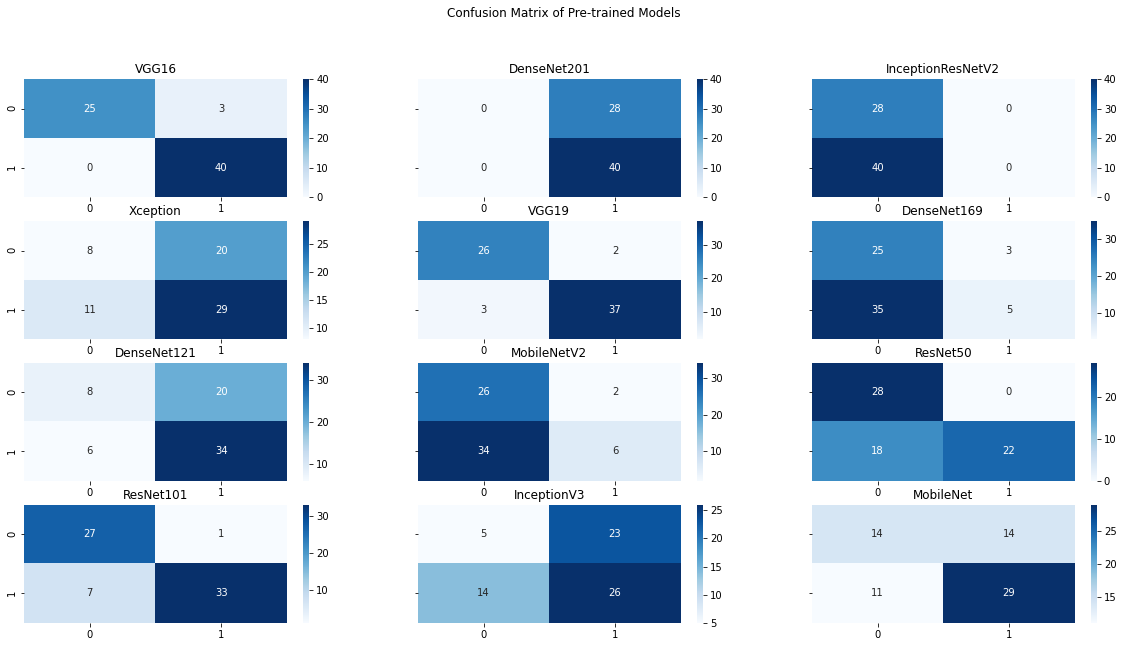

In [78]:
fig, axes = plt.subplots(4, 3, figsize=(20, 10), sharey=True, )
fig.suptitle('Confusion Matrix of Pre-trained Models')
for i, net in enumerate(trained_nets.values()):
    sns.heatmap(nets_evaluation_df.loc[net]['Confusion Matrix'], 
                cmap='Blues', annot=True,ax=axes[i%4, i%3])
    axes[i%4, i%3].set_title(net)


## Custom CNN Models

In [14]:
input_shape = (224, 224, 3) 
NUM_CLASSES = 1

In [15]:

def model_cnn2():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn2 = model_cnn2()



model_cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)     

In [58]:
def model_cnn3():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn3 = model_cnn3()

model_cnn3.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_308 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_402 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_308 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_403 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_309 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 32)    

In [64]:
def model_cnn4():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn4 = model_cnn4()

model_cnn4.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_311 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_405 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_311 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_406 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_312 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 32)    

In [65]:
def model_cnn5():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn5 = model_cnn5()

model_cnn5.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_315 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_409 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_315 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_410 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_316 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 112, 112, 32)    

In [66]:
def model_cnn6():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn6 = model_cnn6()

model_cnn6.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_320 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_414 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_320 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_321 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_415 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_321 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 112, 112, 32)    

In [67]:
def model_cnn7():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn7 = model_cnn7()

model_cnn7.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_326 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_420 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_326 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_327 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_421 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_327 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 112, 112, 32)    

In [68]:
def model_cnn8():
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))

    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
        
    return model

model_cnn8 = model_cnn8()

model_cnn8.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_333 (Conv2D)          (None, 224, 224, 32)      896       
_________________________________________________________________
activation_427 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_333 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_428 (Activation)  (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_334 (Bat (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 112, 112, 32)    

### Custom Models Evaluations Table

In [70]:
custom_models = {model_cnn2 : '2 X CNN', model_cnn3 : '3 X CNN', model_cnn4 : '4 X CNN', model_cnn5 : '5 X CNN',
                model_cnn6 : '6 X CNN', model_cnn7 : '7 X CNN', model_cnn8 : '8 X CNN'}
custom_cnn_evaluation_df = pd.DataFrame(columns=['Training Accuracy', 'Validation Accuracy', 'Test Accuracy', 'F1 Measure', 'Kappa', 'ROC Area'])

In [72]:
for model in custom_models.keys():
    
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy'])
    
    history = model.fit(
    train_generator, 
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))
    
    # validate on test set
    predictions = model.predict(X_test_prep)
    predictions = [1 if x>0.5 else 0 for x in predictions]

    acc = history.history['accuracy']
    
    val_acc = history.history['val_accuracy']

    test_accuracy = accuracy_score(y_test, predictions)

    kappa_score = cohen_kappa_score(y_test, predictions)

    roc_area = roc_auc_score(y_test, predictions)

    (precision, recall, fscore, support) = precision_recall_fscore_support(y_test, predictions, average='macro')
    
    measures = [acc[-1], val_acc[-1], test_accuracy, fscore, kappa_score, roc_area]

    custom_cnn_evaluation_df.loc[custom_models[model]] = measures

Epoch 1/30
16/16 [==============================] - 4s 240ms/step - loss: 1.6422 - accuracy: 0.7231 - val_loss: 0.8556 - val_accuracy: 0.8043
Epoch 2/30
16/16 [==============================] - 4s 221ms/step - loss: 1.4314 - accuracy: 0.7686 - val_loss: 0.0131 - val_accuracy: 0.7717
Epoch 3/30
16/16 [==============================] - 3s 216ms/step - loss: 1.5893 - accuracy: 0.7025 - val_loss: 1.9828 - val_accuracy: 0.8261
Epoch 4/30
16/16 [==============================] - 3s 213ms/step - loss: 1.5678 - accuracy: 0.7562 - val_loss: 1.5120 - val_accuracy: 0.7935
Epoch 5/30
16/16 [==============================] - 3s 212ms/step - loss: 1.4784 - accuracy: 0.7603 - val_loss: 0.8222 - val_accuracy: 0.7935
Epoch 6/30
16/16 [==============================] - 3s 217ms/step - loss: 1.3419 - accuracy: 0.7438 - val_loss: 4.2235 - val_accuracy: 0.6087
Epoch 7/30
16/16 [==============================] - 4s 241ms/step - loss: 1.6547 - accuracy: 0.6983 - val_loss: 0.5335 - val_accuracy: 0.8043
Epoch 

16/16 [==============================] - 3s 213ms/step - loss: 0.8740 - accuracy: 0.7438 - val_loss: 0.2895 - val_accuracy: 0.8478
Epoch 26/30
16/16 [==============================] - 3s 207ms/step - loss: 0.8806 - accuracy: 0.7066 - val_loss: 0.2064 - val_accuracy: 0.8370
Epoch 27/30
16/16 [==============================] - 4s 222ms/step - loss: 1.0041 - accuracy: 0.7273 - val_loss: 0.1701 - val_accuracy: 0.8478
Epoch 28/30
16/16 [==============================] - 3s 214ms/step - loss: 0.8705 - accuracy: 0.7190 - val_loss: 0.4621 - val_accuracy: 0.7935
Epoch 29/30
16/16 [==============================] - 3s 213ms/step - loss: 0.8593 - accuracy: 0.7025 - val_loss: 0.2490 - val_accuracy: 0.7826
Epoch 30/30
16/16 [==============================] - 3s 211ms/step - loss: 0.9387 - accuracy: 0.7479 - val_loss: 0.4875 - val_accuracy: 0.8478
Epoch 1/30
16/16 [==============================] - 5s 293ms/step - loss: 1.1880 - accuracy: 0.5785 - val_loss: 0.6602 - val_accuracy: 0.7065
Epoch 2/30
1

In [73]:
custom_cnn_evaluation_df

,Training Accuracy,Validation Accuracy,Test Accuracy,F1 Measure,Kappa,ROC Area
2 X CNN,0.793388,0.836957,0.842105,0.842105,0.685083,0.844444
3 X CNN,0.785124,0.836957,0.789474,0.788889,0.582418,0.794444
4 X CNN,0.752066,0.826087,0.789474,0.784091,0.586957,0.800000
5 X CNN,0.747934,0.847826,0.789474,0.788889,0.582418,0.794444
6 X CNN,0.723140,0.793478,0.789474,0.788889,0.577778,0.788889
7 X CNN,0.698347,0.739130,0.789474,0.784091,0.586957,0.800000
8 X CNN,0.739669,0.706522,0.684211,0.660714,0.387097,0.700000


In [74]:
nets_evaluation_df = pd.concat([custom_cnn_evaluation_df, nets_evaluation_df])

In [76]:
nets_evaluation_df.to_excel("nets_evaluation.xlsx")

In [77]:
nets_evaluation_df

,Training Accuracy,Validation Accuracy,Test Accuracy,F1 Measure,Kappa,ROC Area
2 X CNN,0.793388,0.836957,0.842105,0.842105,0.685083,0.844444
3 X CNN,0.785124,0.836957,0.789474,0.788889,0.582418,0.794444
4 X CNN,0.752066,0.826087,0.789474,0.784091,0.586957,0.800000
5 X CNN,0.747934,0.847826,0.789474,0.788889,0.582418,0.794444
6 X CNN,0.723140,0.793478,0.789474,0.788889,0.577778,0.788889
7 X CNN,0.698347,0.739130,0.789474,0.784091,0.586957,0.800000
8 X CNN,0.739669,0.706522,0.684211,0.660714,0.387097,0.700000
VGG16,0.855372,0.945652,0.894737,0.894444,0.788889,0.894444
VGG19,0.859504,0.934783,0.789474,0.788889,0.577778,0.788889
ResNet50,0.954545,0.771739,0.684211,0.634615,0.344828,0.666667
